In [1]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#cargamos las librerias necesarias
import wikipedia

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import string
import re

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
page_title = "Cochabamba"    #Busqueda en Wikipedia
text = wikipedia.page(page_title).content

print(text)

Cochabamba (Aymara: Quchapampa; Quechua: Quchapampa) is a city and municipality in central Bolivia in a valley in the Andes mountain range. It is the capital of the Cochabamba Department and the fourth largest city in Bolivia, with a population of 630,587 according to the 2012 Bolivian census. Its name is from a compound of the Quechua words qucha "lake" and pampa, "open plain." Residents of the city and the surrounding areas are commonly referred to as cochalas or, more formally, cochabambinos.
It is known as the "City of Eternal Spring" or "The Garden City" because of its spring-like temperatures all year round. It is also known as "La Llajta," which means "town" in Quechua. It is the largest urban center between the higher capital of La Paz and Santa Cruz de la Sierra in the tropical plains of the east. It sits south-west of the Tunari mountains, and north of the foothills of the Valle Alto. In antiquity, the area featured numerous lakes, which gave the city its name. Many of these 

#Normalizacion

In [4]:
def clean_text(text):
    if isinstance(text, str):  # Verificar si el valor es una cadena de texto
        text = text.lower() # Convertir a minúsculas
        text = re.sub('\[.*?\]', '', text) # Eliminar texto entre corchetes
        text = re.sub('\(.*?\)', '', text) # Eliminar texto entre paréntesis
        text = re.sub('=.+?=', '', text) # Eliminar texto entre signos =
        text = text.replace('\n', '') # Eliminar caracteres \n
        text = text.replace('=', '') # Eliminar caracteres \n
        
    return text

In [5]:
#Aplicamos la funcion de limpieza y normalizacion al texto
text = clean_text(text)
print(text)

cochabamba  is a city and municipality in central bolivia in a valley in the andes mountain range. it is the capital of the cochabamba department and the fourth largest city in bolivia, with a population of 630,587 according to the 2012 bolivian census. its name is from a compound of the quechua words qucha "lake" and pampa, "open plain." residents of the city and the surrounding areas are commonly referred to as cochalas or, more formally, cochabambinos.it is known as the "city of eternal spring" or "the garden city" because of its spring-like temperatures all year round. it is also known as "la llajta," which means "town" in quechua. it is the largest urban center between the higher capital of la paz and santa cruz de la sierra in the tropical plains of the east. it sits south-west of the tunari mountains, and north of the foothills of the valle alto. in antiquity, the area featured numerous lakes, which gave the city its name. many of these lakes have since disappeared to urban deve

In [6]:
#Verificamos la cantidad de caracteres que contiene el texto Normalizado para al final comparar con el Summary
len(text)

23034

Una ves normalizado el texto convirtiendo a minisculas y eliminando algunos caracteres especiales que consideramos, vemos que para este ejemplo tenemos 10298 caracteres

#Spacy

In [7]:
# Spacy
nlp = spacy.load('en_core_web_sm')#Cargamos un modelo pre entrenado en ingles de Spacy
sentences = list(nlp(text).sents)#con el modelo cargado en "nlp" y convertimos el texto en diviciones de oraciones con el medoto "sent"


In [8]:
#imprimimos las oraciones divididas
print(sentences)

[cochabamba  is a city and municipality in central bolivia in a valley in the andes mountain range., it is the capital of the cochabamba department and the fourth largest city in bolivia, with a population of 630,587 according to the 2012 bolivian census., its name is from a compound of the quechua words qucha "lake" and pampa, "open plain.", residents of the city and the surrounding areas are commonly referred to as cochalas or, more formally, cochabambinos.it is known as the "city of eternal spring" or "the garden city" because of its spring-like temperatures all year round., it is also known as "la llajta," which means "town" in quechua., it is the largest urban center between the higher capital of la paz and santa cruz de la sierra in the tropical plains of the east., it sits south-west of the tunari mountains, and north of the foothills of the valle alto., in antiquity, the area featured numerous lakes, which gave the city its name., many of these lakes have since disappeared to u

In [9]:
#imprimimos la cantidad de oraciones
len(sentences)

124

In [10]:
#Limpiamos las oraciones eliminando las palabras stopwords de las oraciones
cleaned_sentences = []    #creamos una lista vacia para almacenar las oraciones limpias
for sentence in sentences:
    words = [token.text.lower() for token in sentence if not token.is_stop]#crea una lista con las palabras mas comunes(stopwords) de todas las oraciones
    cleaned_sentences.append(' '.join(words))# agrega las oraciones excluyendo los stopwords procesadas en words

In [11]:
#imprimimos las palabras mas comunes de las oraciones(stopwords) que fueron eliminados de las oraciones
print(words)

['oclc', '1247798.weather', 'cochabambathe', 'history', 'cochabamba', 'cbba.info', 'archived', '2020', '-', '10', '-', '23', 'wayback', 'machine', 'map', 'cochabamba', 'city']


In [12]:
#Imprimimos las oraciones sin stopwords generado
cleaned_sentences

['cochabamba   city municipality central bolivia valley andes mountain range .',
 'capital cochabamba department fourth largest city bolivia , population 630,587 according 2012 bolivian census .',
 'compound quechua words qucha " lake " pampa , " open plain . "',
 'residents city surrounding areas commonly referred cochalas , formally , cochabambinos.it known " city eternal spring " " garden city " spring - like temperatures year round .',
 'known " la llajta , " means " town " quechua .',
 'largest urban center higher capital la paz santa cruz de la sierra tropical plains east .',
 'sits south - west tunari mountains , north foothills valle alto .',
 'antiquity , area featured numerous lakes , gave city .',
 'lakes disappeared urban development , coña coña alalay lakes extant examples .',
 'populated settlement pre - inca period , today important cultural , educational , political , commercial centre .',
 'pre - inca inca cochabamba valley inhabited thousands years fertile productive 

In [13]:
#imprimimos la cantidad de de oraciones 
len(cleaned_sentences)

124

##Vectorizacion

In [14]:
#Transformamos vectores
X = [nlp(sentence).vector for sentence in cleaned_sentences]#creamos vectores delas oraciones limpias con Spacy usando el metodo vector

#Normalizamos el Tamano de los Vectores de X para entrenar en un modelo de Machine Learning
vector_size = len(X[0])#calculamos el tamano del 1er Vector

#creamos un buclue que recorre X y rellena el vector con 0  si tiene una longitud menor a vecto_size
for i in range(len(X)):
    if len(X[i]) < vector_size:
        X[i] = np.pad(X[i], (0, vector_size - len(X[i])), mode='constant')

#convertimos el vector de Spacy en un vector de Numpy para entrenar el modelo
X = np.array(X)


In [15]:
print(X)

[[ 0.800116   -0.19890665  0.27203834 ...  1.0547738   0.3375662
   0.86240077]
 [ 0.3025392   0.17308742  0.11357369 ...  0.28451484  0.2793358
   0.62801844]
 [ 0.03588933  0.3417285   0.5869073  ...  0.16604733 -0.05921127
   0.6622886 ]
 ...
 [ 0.98168546  0.04740571  0.48054156 ...  1.1087029   0.20555031
   1.3457665 ]
 [ 0.5517541  -0.17330095  0.01242772 ...  0.28386992  0.7687798
   0.05830552]
 [ 0.5091643  -0.13902938 -0.32968077 ...  1.0509195   0.290488
   0.5217196 ]]


##COSSINE SIMILARITY

In [16]:
similarity_matrix = cosine_similarity(X)#se calcula  la matriz de similitud entre las oraciones de sus vectores
np.fill_diagonal(similarity_matrix, 0)

##Random Forest

In [17]:
# Se entrenara un modelo de regresión aleatoria para predecir la importancia de cada oración

y = np.sum(similarity_matrix, axis=1)#Calcula la puntuacion de importacia de cada oracion con las demas oraciones
X_train, X_test, y_train, y_test = train_test_split(similarity_matrix, y, test_size=0.80, random_state=123)#dividimos los vectores en entrenamiento y prueba 


#aplicamos y entrenamos el modelo Random Forest
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [18]:
# Predecimos la importancia de cada oración en el conjunto de prueba utilizando el modelo entrenado
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo en el conjunto de prueba
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)

In [19]:
#utilizamos el modelo entrenado de RF para predecir la importancia de cada oracion
rf_sentence_scores = rf_model.predict(similarity_matrix)

In [20]:
#imprimimos la importancia que tiene cada oracion donde se espera que las oraciones mas importantes tengas puntajes altos
print(rf_sentence_scores)

[74.83915817 75.07461334 58.34165276 65.80142902 51.42711842 70.19087257
 70.12559326 55.89679764 73.20508881 58.41703598 75.47019535 74.88321274
 68.25515175 74.31784702 65.70369244 74.9761306  76.27717918 62.42079475
 75.89695419 77.01959938 51.64847748 70.74080528 70.61706516 74.29666798
 71.73151127 79.11259956 74.12814056 66.86369972 61.73730339 49.78248989
 62.85223141 47.10231564 48.17493061 75.08073845 55.29561699 74.35363674
 73.82968933 62.67301449 73.53635109 64.8841087  59.47317738 76.77815269
 58.69035713 50.30566357 70.94110756 59.23875088 61.71148579 76.40906548
 75.52937073 76.95371948 61.58948986 59.97514816 74.226623   69.36487858
 71.26537781 73.17060791 73.56855904 68.09783043 70.92179848 53.87699497
 74.28816074 73.61861237 75.81027302 73.83977188 72.32097038 78.657799
 73.31278961 71.44600311 72.97707863 74.45326515 71.88798553 74.33361008
 72.60839035 77.06404762 64.66610767 70.63387939 70.95487679 47.10016396
 69.94125694 75.94626541 75.8798658  75.26162388 60.7

In [21]:
#Ordenamos las oraciones mas relevantes en orden descendente
rf_top_sentences = sorted(range(len(rf_sentence_scores)), key=lambda i: rf_sentence_scores[i], reverse=True)[:10]#seleccinamos las 5 oraciones mas relevantes
print(rf_top_sentences)#imprimios del total de oraciones, que oraciones son las mas relevantes


[109, 25, 65, 96, 107, 97, 73, 19, 49, 41]


In [22]:
#de la lista de oraciones originales tomamos las las 5 oraciones de top_sentence
rf_summary = [sentences[i].text for i in rf_top_sentences]
print(rf_summary)#imprimimos las 5 oraciones  

['the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus.', "however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba.", 'in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country.', 'cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city.', 'powerful drug lord alejandro sosa r

In [23]:
rf_summary = ' '.join(rf_summary)#unimos las oraciones para crear un resumen
print(rf_summary)#impresion del resumen

the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus. however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba. in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country. cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city. powerful drug lord alejandro sosa resided there, 

In [24]:
#imprimos la cantidad de caracteres del Resumen con Random Forest
print("Cantidad de caracteres del Resumen con Random Forest:", len(rf_summary))
print("Cantidad de caracteres del Texto original:", len(text))

Cantidad de caracteres del Resumen con Random Forest: 2141
Cantidad de caracteres del Texto original: 23034


#Gradient Boosting

In [25]:
#aplicamos y entrenamos el modelo
gb_model = GradientBoostingRegressor(random_state=123)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

In [26]:
y_pred = gb_model.predict(X_test)

In [27]:
gb_r2 = r2_score(y_test, y_pred)
gb_mse = mean_squared_error(y_test, y_pred)

In [28]:
# Entrenamos el modelo entrenado en matriz de similitud
gb_sentence_scores = gb_model.predict(similarity_matrix)

In [29]:
#Ordenamos las oraciones mas relevantes en orden descendente
gb_top_sentences = sorted(range(len(gb_sentence_scores)), key=lambda i: gb_sentence_scores[i], reverse=True)[:10]#seleccinamos las 5 oraciones mas relevantes
print(gb_top_sentences)#imprimios del total de oraciones, que oraciones son las mas relevantes

[109, 96, 65, 25, 107, 97, 19, 16, 15, 73]


In [30]:
#de la lista de oraciones originales tomamos las las 5 oraciones de top_sentence
gb_summary = [sentences[i].text for i in gb_top_sentences]
print(gb_summary)#imprimimos las 5 oraciones  

['the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus.', 'cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city.', 'in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country.', "however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba.", 'powerful drug lord alejandro sosa r

In [31]:
gb_summary = ' '.join(gb_summary)#unimos las oraciones para crear un resumen
print(gb_summary)#impresion del resumen

the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus. cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city. in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country. however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba. powerful drug lord alejandro sosa resided there, 

In [32]:
#imprimos la cantidad de caracteres del Resumen con Random Forest
print("Cantidad de caracteres del Resumen con Gradient Boosting:", len(gb_summary))
print("Cantidad de caracteres del Texto original:", len(text))

Cantidad de caracteres del Resumen con Gradient Boosting: 2036
Cantidad de caracteres del Texto original: 23034


#SVM

In [33]:
#aplicamos y entrenamos el modelo SVM
svr_model = SVR(kernel='linear')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)

In [34]:
svr_r2 = r2_score(y_test, y_pred)
svr_mse = mean_squared_error(y_test, y_pred)

In [35]:
# Entrenamos el modelo entrenado en matriz de similitud
svr_sentence_scores = svr_model.predict(similarity_matrix)
#Ordenamos las oraciones mas relevantes en orden descendente
svr_top_sentences = sorted(range(len(svr_sentence_scores)), key=lambda i: svr_sentence_scores[i], reverse=True)[:10]#seleccinamos las 5 oraciones mas relevantes
print(svr_top_sentences)#imprimios del total de oraciones, que oraciones son las mas relevantes

[109, 65, 96, 25, 41, 79, 107, 49, 97, 33]


In [36]:
#de la lista de oraciones originales tomamos las las 5 oraciones de top_sentence
svr_summary = [sentences[i].text for i in svr_top_sentences]
svr_summary = ' '.join(svr_summary)#unimos las oraciones para crear un resumen
print(svr_summary)#impresion del resumen

the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus. in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country. cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city. however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba. the coalition for the defense of water and life, 

In [37]:
#imprimos la cantidad de caracteres del Resumen con 
print("Cantidad de caracteres del Resumen con SVR:", len(svr_summary))
print("Cantidad de caracteres del Texto original:", len(text))

Cantidad de caracteres del Resumen con SVR: 2235
Cantidad de caracteres del Texto original: 23034


#Decision Tree

In [38]:
#aplicamos y entrenamos el modelo
dt_model = DecisionTreeRegressor(random_state=123)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [39]:
dt_r2 = r2_score(y_test, y_pred)
dt_mse = mean_squared_error(y_test, y_pred)

In [40]:
# Entrenamos el modelo entrenado en matriz de similitud
dt_sentence_scores = dt_model.predict(similarity_matrix)
#Ordenamos las oraciones mas relevantes en orden descendente
dt_top_sentences = sorted(range(len(dt_sentence_scores)), key=lambda i: dt_sentence_scores[i], reverse=True)[:10]#seleccinamos las 5 oraciones mas relevantes
print(dt_top_sentences)#imprimios del total de oraciones, que oraciones son las mas relevantes

[109, 62, 63, 96, 110, 111, 25, 38, 79, 33]


In [41]:
#de la lista de oraciones originales tomamos las las 5 oraciones de top_sentence
dt_summary = [sentences[i].text for i in dt_top_sentences]
dt_summary = ' '.join(dt_summary)#unimos las oraciones para crear un resumen
print(dt_summary)#impresion del resumen

the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus. its central commercial districts, zona norte, is bounded by plaza colón and plaza 14 de septiembre, are generally equipped with modern urban amenities and are where the majority of the city's formal business and commercial industries are based. la cancha, the largest open-air market in south america, is also an active place where locals can buy a range of items. cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city. business people simón iturri patiño , mining magnateeducators and intellectualsjaime escalante, professor and teacher whose life was dramatized in the 1988 film stand and deliverrenato prada oropeza, professor, semiologist, writerthäddeus haenke , botanist musicians katia escalera, sopr

In [42]:
#imprimos la cantidad de caracteres del Resumen con 
print("Cantidad de caracteres del Resumen con Desicion Tree:", len(dt_summary))
print("Cantidad de caracteres del Texto original:", len(text))

Cantidad de caracteres del Resumen con Desicion Tree: 2599
Cantidad de caracteres del Texto original: 23034


#Final Summary

In [43]:
#creamos una lista para almacenar R2 de los modelos de regresion
r2_list = [rf_r2 *100, gb_r2 *100,svr_r2 *100, dt_r2 *100]
#creamos una lista para almacenar R2 de los modelos de regresion
mse_list = [rf_mse , gb_mse ,svr_mse, dt_mse]

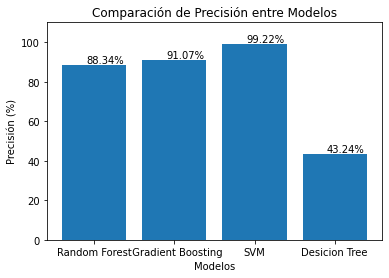

In [44]:
plt.bar(['Random Forest', '  Gradient Boosting','SVM','Desicion Tree'], r2_list)
plt.xlabel('Modelos')
plt.ylabel('Precisión (%)')
plt.title('Comparación de Precisión entre Modelos')
plt.ylim([0, 110])
for i, v in enumerate(r2_list):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) + '%')
plt.show()

Tenemos que SVM es el mejor modelo para predecir las mejores oraciones pero por el nivel de presicion puede que este sobre entrenado.

aun asi los 2 primeros modelos son considerablemente buenos

Comentar que este modelo la presicion en R2 cambia de a cuardo a la cantidad de oraciones que genere Spacy a menor oracion el R2 del modelo sera menor

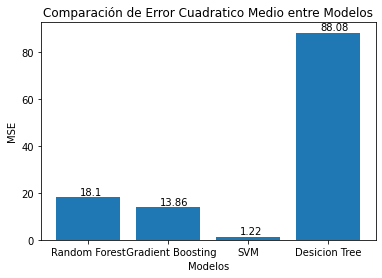

In [45]:
plt.bar(['Random Forest', '  Gradient Boosting','SVM','Desicion Tree'], mse_list)
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparación de Error Cuadratico Medio entre Modelos')
#plt.ylim([0, 110])
for i, v in enumerate(mse_list):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) )
plt.show()

In [46]:
#imprimimos la lista de las 10 oraciones mas relevantes para cada Modelo
print("Lista de las Oraciones mas relevantes de Random Forest:   ",rf_top_sentences)
print("Lista de las Oraciones mas relevantes de Gradient Bosting:",gb_top_sentences)
print("Lista de las Oraciones mas relevantes de SVM:             ",svr_top_sentences)
print("Lista de las Oraciones mas relevantes de Desicion Tree:   ",dt_top_sentences)

Lista de las Oraciones mas relevantes de Random Forest:    [109, 25, 65, 96, 107, 97, 73, 19, 49, 41]
Lista de las Oraciones mas relevantes de Gradient Bosting: [109, 96, 65, 25, 107, 97, 19, 16, 15, 73]
Lista de las Oraciones mas relevantes de SVM:              [109, 65, 96, 25, 41, 79, 107, 49, 97, 33]
Lista de las Oraciones mas relevantes de Desicion Tree:    [109, 62, 63, 96, 110, 111, 25, 38, 79, 33]


Por el orden de las oraciones se puede ver que existe similitudes en el numero de oracion a considerar para el resumen variando en muy poco el resumen

In [47]:
#imprimimos la cantidad de caracteres que tiene el resumen
print("Cantidad de caracteres con Random Forest:   ",len(rf_summary))
print("Cantidad de caracteres con Gradient Bosting:",len(gb_summary))
print("Cantidad de caracteres con SVM:             ",len(svr_summary))
print("Cantidad de caracteres con Desicion Tree:   ",len(dt_summary))
print("Cantidad de caracteres del Texto original   ",len(text))


Cantidad de caracteres con Random Forest:    2141
Cantidad de caracteres con Gradient Bosting: 2036
Cantidad de caracteres con SVM:              2235
Cantidad de caracteres con Desicion Tree:    2599
Cantidad de caracteres del Texto original    23034


In [48]:
#imprimimos los resumenes
print("Resumen con Random Forest:   ",rf_summary)
print("Resumen con Gradient Bosting:",gb_summary)
print("Resumen con SVM:             ",svr_summary)
print("Resumen con Desicion Tree:   ",dt_summary)

Resumen con Random Forest:    the film stars mexican actor gael garcía bernal, and received positive reviews.cochabamba is also the site of several major spammers, as confirmed by the watchdog group spamhaus. however, the city entered a period of decline during the 18th century as mining began to wane.in 1786, king charles iii of spain renamed the city the 'loyal and valiant' villa of cochabamba. in contrast, the zona sur, a remote area adjacent to the wilstermann international airport is visibly impoverished, with adobe homes and unpaved roads, which is often the first impression visitors acquire while commuting into the city.in 2009, the government under president evo morales created a new constitution that declared spanish and 36 other indigenous languages as the official languages of the country. cochabamba became the second recipient city of brazilian students in bolivia after the city of santa cruz, due to the affordable and good living conditions of the city. powerful drug lord 